## Necessary packages and functions call

- timegan: Synthetic time-series data generation module
- data_loading: 2 real datasets and 1 synthetic datasets loading and preprocessing
- metrics: 
    - discriminative_metrics: classify real data from synthetic data
    - predictive_metrics: train on synthetic, test on real
    - visualization: PCA and tSNE analyses

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import sys
sys.path.append(os.path.join(os.path.dirname('__file__'), '../'))

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [2]:
## Necessary packages
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


import warnings
warnings.filterwarnings("ignore")

# 3. Metrics
from discriminative_score_metrics import discriminative_score_metrics
from predictive_score_metrics import predictive_score_metrics
from metric_utils import display_scores, visualization
import seaborn as sns

In [3]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

def real_data_loading(data_name, seq_len):

    df = pd.read_csv(f'../datasets/{data_name}.csv', header=0)

    # Preprocess the data
    df = df.dropna()  # Handle missing values by dropping them
    data = df.values

    # Normalize the data (example: min-max normalization)
    scaler = MinMaxScaler()
    scaler.fit(data)
    normalized_data = scaler.transform(data)

    # Create sequences of length seq_len
    sequences = []
    for i in range(len(normalized_data) - seq_len + 1):
        sequences.append(normalized_data[i:i+seq_len])

    data = np.array(sequences)

    np.save(os.path.join('../generated_datasets/real_data_npy/', f"{data_name}.npy"), data)

    return data

## Data Loading

Load original dataset and preprocess the loaded data.

- data_name: stock, energy, or sine
- seq_len: sequence length of the time-series data

In [4]:
## Data loading
data_name = 'ETTh2'
seq_len = 64
ori_data = real_data_loading(data_name, seq_len)
print(len(ori_data))

ckpt_name = f'model_{data_name}_generate_uncond_64'
generated_data = np.load(f'../generated_datasets/{ckpt_name}.npy')[:len(ori_data), :, :]
ori_data = ori_data[:len(generated_data), :, :]
print(len(ori_data))
print(data_name + ' dataset is ready.')

FileNotFoundError: [Errno 2] No such file or directory: '../datasets/ETTh2.csv'

## Evaluate the generated data

### 1. Visualization

We visualize the original and synthetic data distributions using PCA and tSNE analysis.

3.7.5


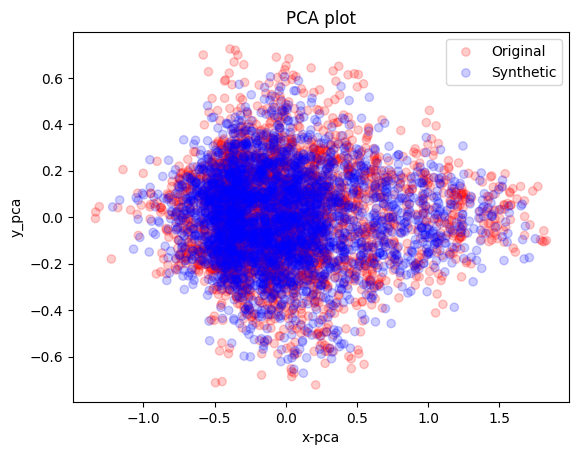

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6000 samples in 0.000s...
[t-SNE] Computed neighbors for 6000 samples in 0.083s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6000
[t-SNE] Computed conditional probabilities for sample 2000 / 6000
[t-SNE] Computed conditional probabilities for sample 3000 / 6000
[t-SNE] Computed conditional probabilities for sample 4000 / 6000
[t-SNE] Computed conditional probabilities for sample 5000 / 6000
[t-SNE] Computed conditional probabilities for sample 6000 / 6000
[t-SNE] Mean sigma: 0.113021
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.895699
[t-SNE] KL divergence after 300 iterations: 2.567007


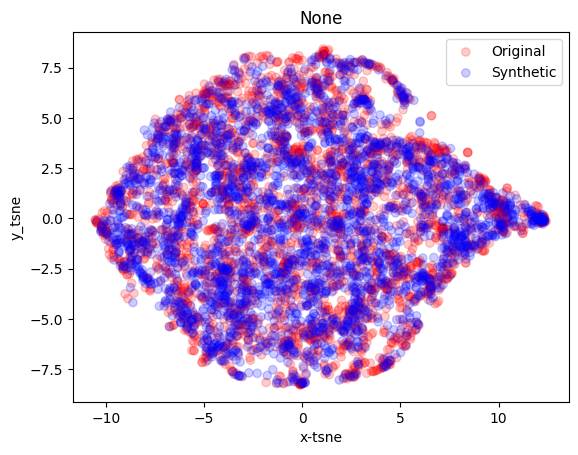

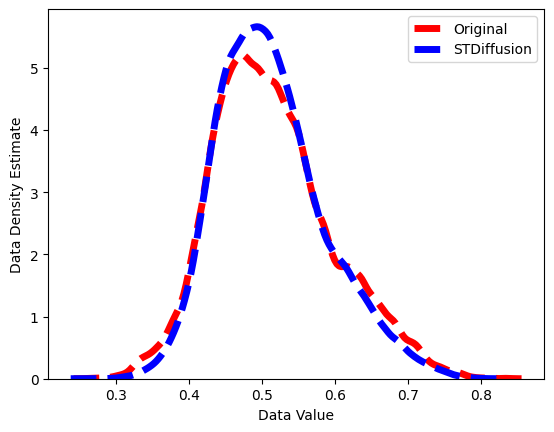

In [18]:
import matplotlib
print(matplotlib.__version__)
visualization(ori_data, generated_data, 'pca')
visualization(ori_data, generated_data, 'tsne')
visualization(ori_data, generated_data, 'kernel')

## Evaluate the generated data

### 2. Discriminative score

To evaluate the classification accuracy between original and synthetic data using post-hoc RNN network. The output is |classification accuracy - 0.5|.

- metric_iteration: the number of iterations for metric computation.

In [26]:
metric_iteration = 5
discriminative_score = list()
for _ in range(metric_iteration):
  temp_disc, fake_acc, real_acc = discriminative_score_metrics(ori_data, generated_data)
  print(f'fake acc: {fake_acc}, real acc: {real_acc}, dis_score: {temp_disc}')
  discriminative_score.append(temp_disc)

display_scores(discriminative_score)


training: 100%|██████████| 2000/2000 [00:46<00:00, 43.34it/s]


fake acc: 0.6514976958525346, real acc: 0.4835829493087558, dis_score: 0.06754032258064513


training: 100%|██████████| 2000/2000 [00:46<00:00, 42.97it/s]


fake acc: 0.6336405529953917, real acc: 0.4861751152073733, dis_score: 0.05990783410138245


training: 100%|██████████| 2000/2000 [00:46<00:00, 43.48it/s]


fake acc: 0.6235599078341014, real acc: 0.49222350230414746, dis_score: 0.057891705069124444


training: 100%|██████████| 2000/2000 [00:46<00:00, 43.42it/s]


fake acc: 0.6690668202764977, real acc: 0.47523041474654376, dis_score: 0.07214861751152069


training: 100%|██████████| 2000/2000 [00:46<00:00, 43.44it/s]

fake acc: 0.6226958525345622, real acc: 0.4737903225806452, dis_score: 0.04824308755760365
Final Score:  0.06114631336405527 ± 0.011456892192496496


## Evaluate the generated data

### 3. Predictive score

To evaluate the prediction performance on train on synthetic, test on real setting. More specifically, we use Post-hoc RNN architecture to predict one-step ahead and report the performance in terms of MAE.

In [20]:
predictive_score = list()
for tt in range(metric_iteration):
  temp_pred = predictive_score_metrics(ori_data, generated_data)
  print(f'pred_score: {temp_pred}')
  predictive_score.append(temp_pred)   
    
# print('Predictive score: ' + str(np.round(np.mean(predictive_score), 4)))
display_scores(predictive_score)

training: 100%|██████████| 5000/5000 [01:18<00:00, 63.31it/s]


pred_score: 0.11524216568410374


training: 100%|██████████| 5000/5000 [01:16<00:00, 65.05it/s]


pred_score: 0.1140374621461366


training: 100%|██████████| 5000/5000 [01:16<00:00, 65.63it/s]


pred_score: 0.11394566507104198


training: 100%|██████████| 5000/5000 [01:21<00:00, 61.53it/s]


pred_score: 0.10883833251052621


training: 100%|██████████| 5000/5000 [01:20<00:00, 62.03it/s]


pred_score: 0.12045063247343568
Final Score:  0.11450285157704884 ± 0.005139667983655296
